In [6]:
# -- Imports

%run predict_notebook_sections/imports.ipynb

In [7]:
# -- Functions

%run functions.ipynb

In [8]:
# -- Init Configuration Parameters

%run predict_notebook_sections/configuration.ipynb

Configuration file loaded: config-train_ticket.ini


In [9]:
# -- Autoencoder Model Setup

%run predict_notebook_sections/autoencoder_model_setup.ipynb

In [10]:
# Load data sets config
data_sets_config = load_data_sets_config(data_sets_config_file_path)

In [11]:
# -- Loadings

%run predict_notebook_sections/loadings.ipynb

Training data set loaded ( output/output-train_ticket/datasets/Normalized/normal-2weeks.csv ): (19996, 8164)
Loading the production data sets ..
output/output-train_ticket/datasets/Normalized/linear-cpu-stress-ts-station-service-020211.csv (181, 8164)
output/output-train_ticket/datasets/Normalized/linear-cpu-stress-ts-basic-service-020616.csv (180, 8164)
output/output-train_ticket/datasets/Normalized/linear-cpu-stress-ts-train-service-020713.csv (181, 8164)
output/output-train_ticket/datasets/Normalized/linear-memory-stress-ts-station-service-021917.csv (241, 8164)
output/output-train_ticket/datasets/Normalized/linear-memory-stress-ts-train-service-021316.csv (240, 8164)
output/output-train_ticket/datasets/Normalized/linear-memory-stress-ts-basic-service-022009.csv (240, 8164)
output/output-train_ticket/datasets/Normalized/linear-network-delay-ts-station-service-013016.csv (180, 8164)
output/output-train_ticket/datasets/Normalized/linear-network-delay-ts-basic-service-020911.csv (181, 

In [12]:
# -- Create the training and validation sub-data sets (arrays and DFs)

%run predict_notebook_sections/create_training_validation_sub_data_sets.ipynb

In [13]:
# Transform the training data set to the pandas data frame
train_df = pd.DataFrame(train_data, columns=kpi_set)

Epoch 1/5


2024-03-05 17:10:18.252438: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


63/63 [==============================] - 19s 284ms/step - loss: 3524622.0000 - val_loss: 8171.0630
Epoch 2/5
63/63 [==============================] - 18s 286ms/step - loss: 6123.2773 - val_loss: 6488.6167
Epoch 3/5
63/63 [==============================] - 18s 291ms/step - loss: 5346.7373 - val_loss: 6158.7983
Epoch 4/5
63/63 [==============================] - 18s 288ms/step - loss: 5206.1655 - val_loss: 6104.4131
Epoch 5/5
63/63 [==============================] - 18s 294ms/step - loss: 5174.8066 - val_loss: 6080.8374
INFO:tensorflow:Assets written to: output/output-train_ticket/models/Autoencoders/model_13/assets


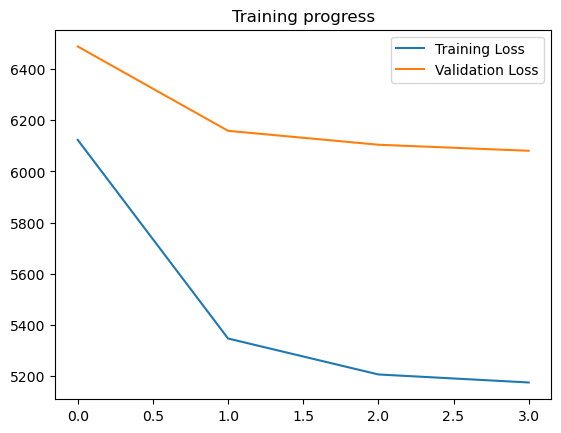

In [14]:
# -- Train or Load the AutoEncoder model

%run predict_notebook_sections/train_or_load_autoencoder.ipynb

In [15]:
# -- Calculate the KPI-level Reconstruction Error Thresholds

%run predict_notebook_sections/calculate_metric_level_thresholds.ipynb

500/500 [==============================] - 11s 22ms/step


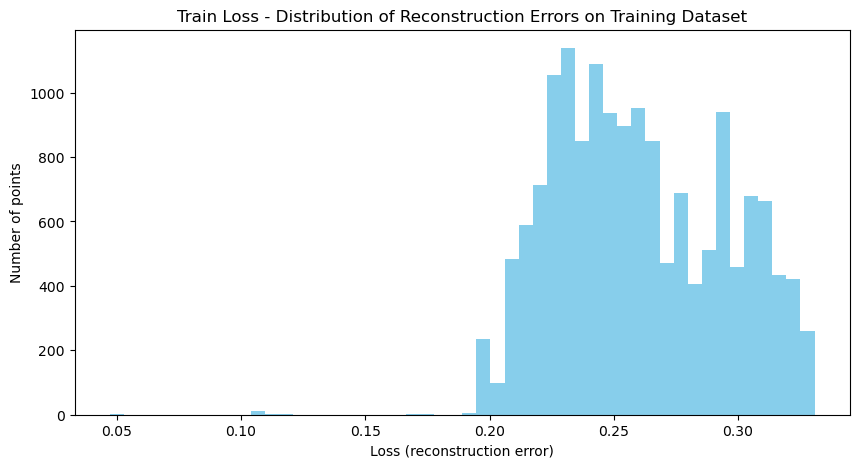

Mean: 0.2602031592405669 Median: 0.25624411880213993 Std Deviation: 0.0339472323004374 Threshold UP:  0.3580858157034521


In [16]:
# -- Calculate the Point-level Reconstruction Error Threshold

%run predict_notebook_sections/calculate_point_level_threshold.ipynb

In [17]:
# -- Make Reconstructions on production data sets

# Create a list of numpy.ndarrays of the test DFs values
# and
# Get the KPIs'reconstructions of each point (output: list of lists of the reconstructed metrics)

test_data_arrays = []
test_reconstructions = []

for data_set_code in prod_data_set_codes:
    
    prod_dfs[data_set_code].fillna(0, inplace=True)
    
    # Create a numpy.ndarray of the DF values
    test_data = prod_dfs[data_set_code].values
    test_data = test_data.astype(float)
    
    test_data_arrays.append(test_data)
    test_reconstructions.append(autoencoder.predict(test_data))

    print(data_set_code, prod_dfs[data_set_code].shape, np.shape(test_data))

6/6 [==============================] - 0s 25ms/step
linear-cpu-stress-ts-station-service-020211 (181, 8164) (181, 8164)
6/6 [==============================] - 0s 26ms/step
linear-cpu-stress-ts-basic-service-020616 (180, 8164) (180, 8164)
6/6 [==============================] - 0s 22ms/step
linear-cpu-stress-ts-train-service-020713 (181, 8164) (181, 8164)
8/8 [==============================] - 0s 23ms/step
linear-memory-stress-ts-station-service-021917 (241, 8164) (241, 8164)
8/8 [==============================] - 0s 21ms/step
linear-memory-stress-ts-train-service-021316 (240, 8164) (240, 8164)
8/8 [==============================] - 0s 24ms/step
linear-memory-stress-ts-basic-service-022009 (240, 8164) (240, 8164)
6/6 [==============================] - 0s 22ms/step
linear-network-delay-ts-station-service-013016 (180, 8164) (180, 8164)
6/6 [==============================] - 0s 22ms/step
linear-network-delay-ts-basic-service-020911 (181, 8164) (181, 8164)
6/6 [==============================

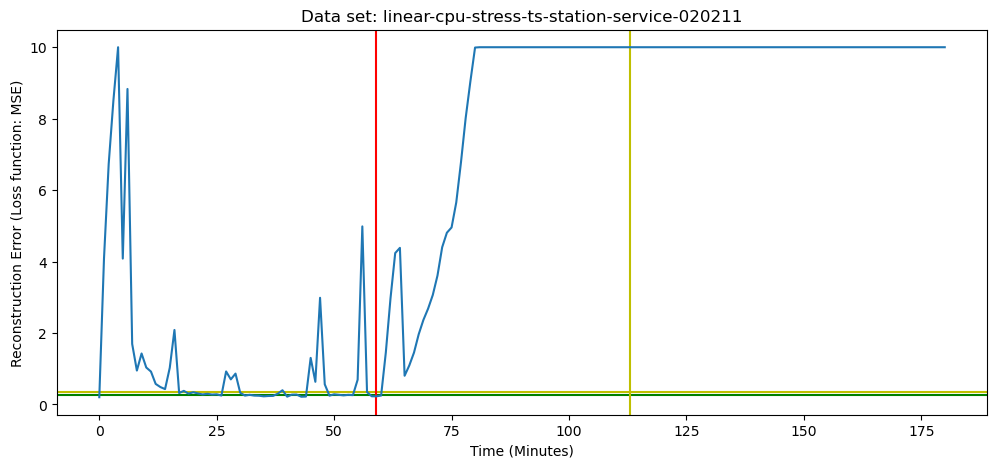

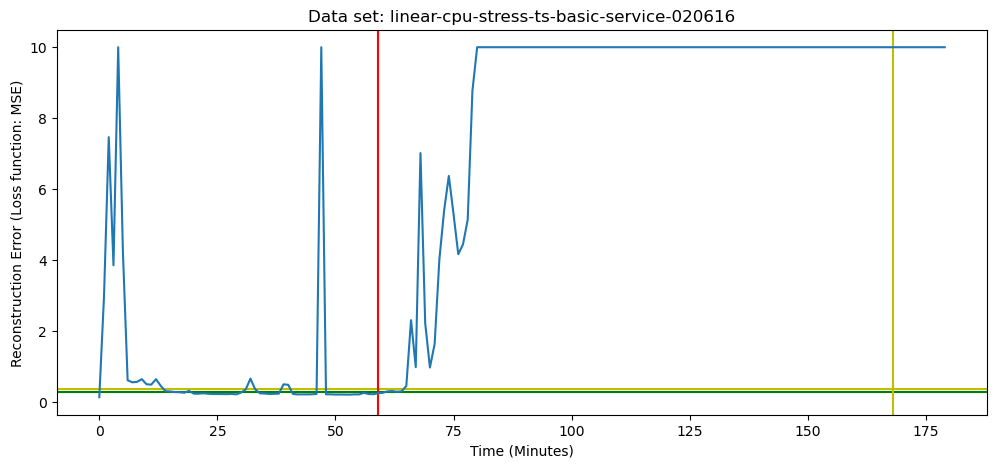

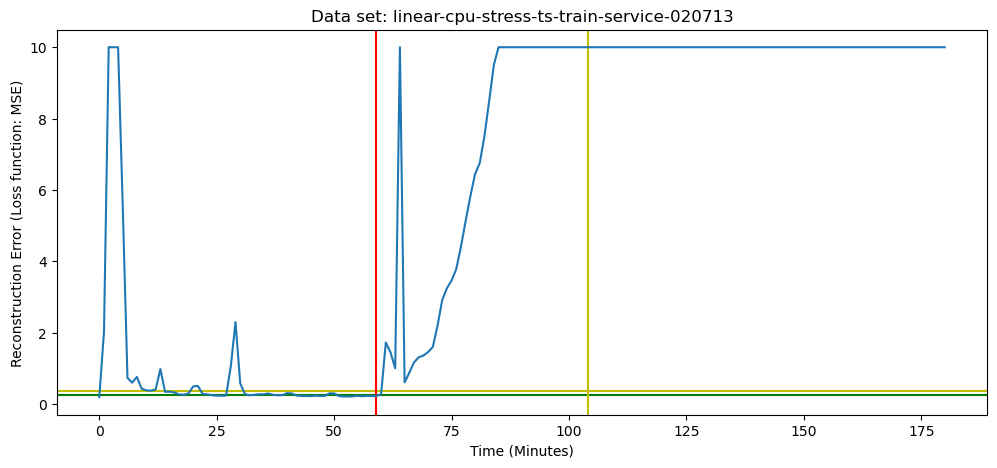

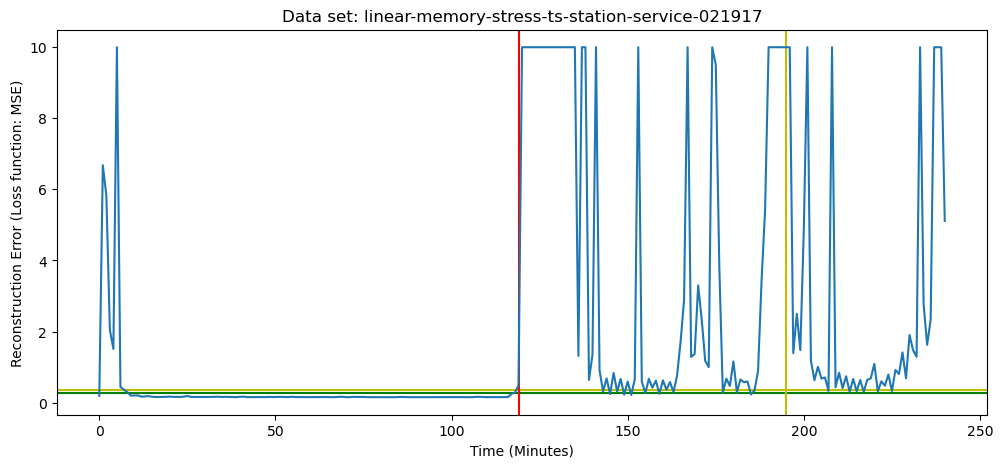

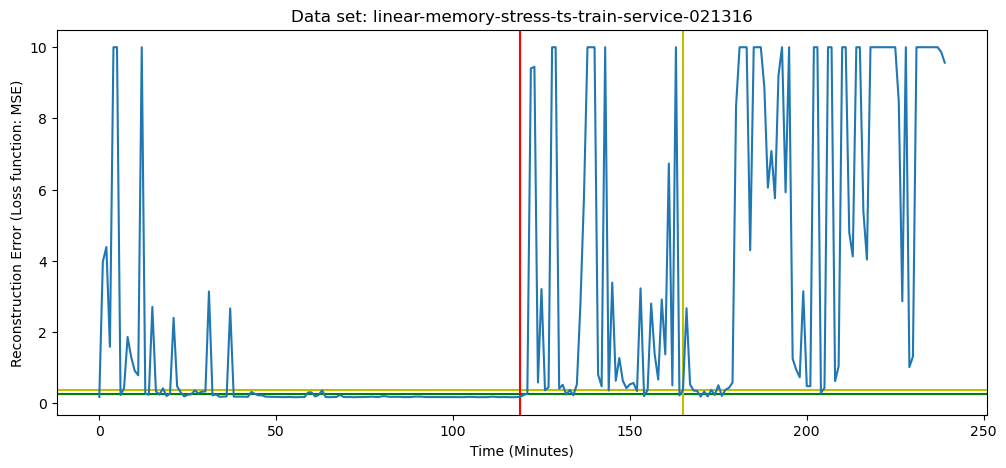

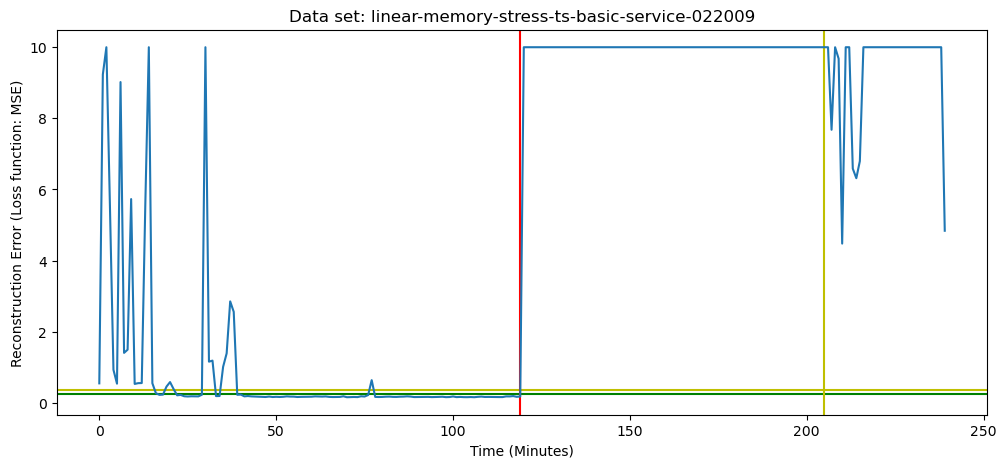

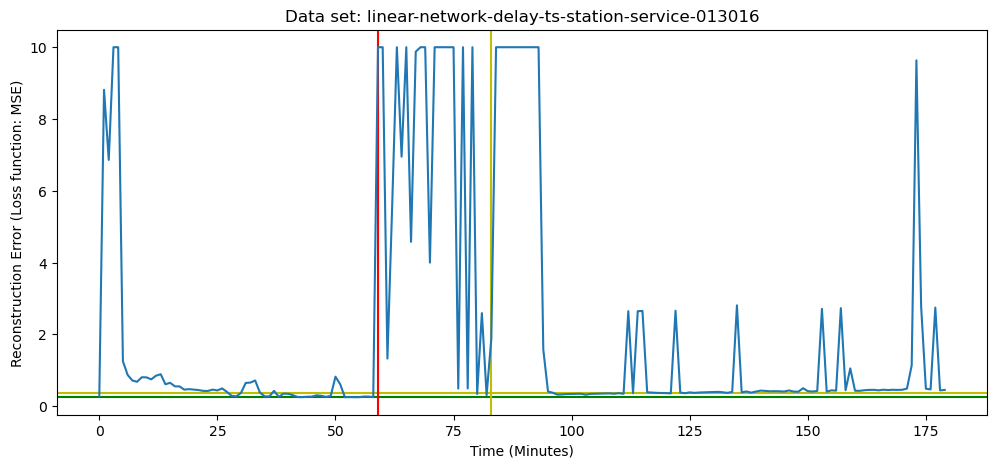

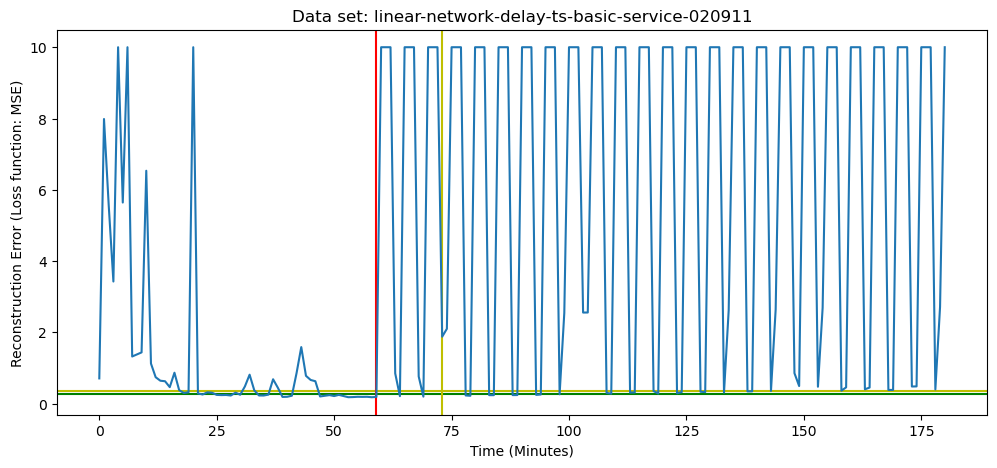

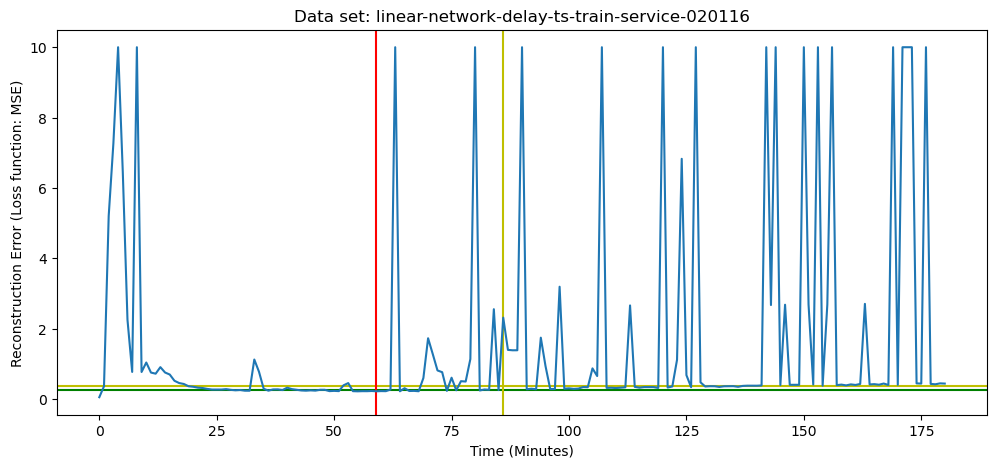

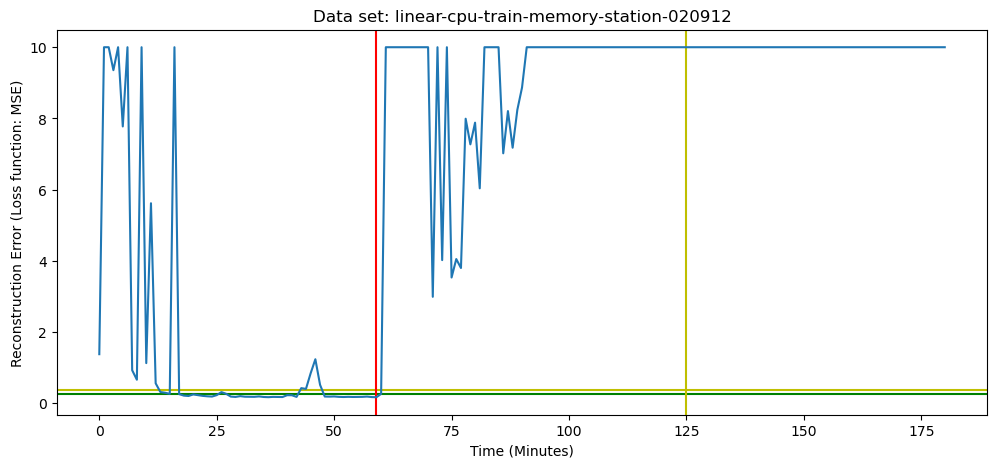

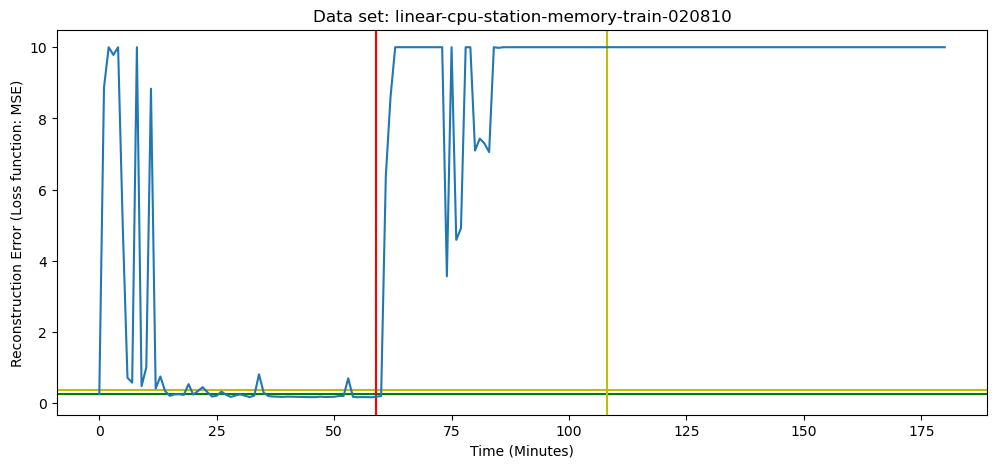

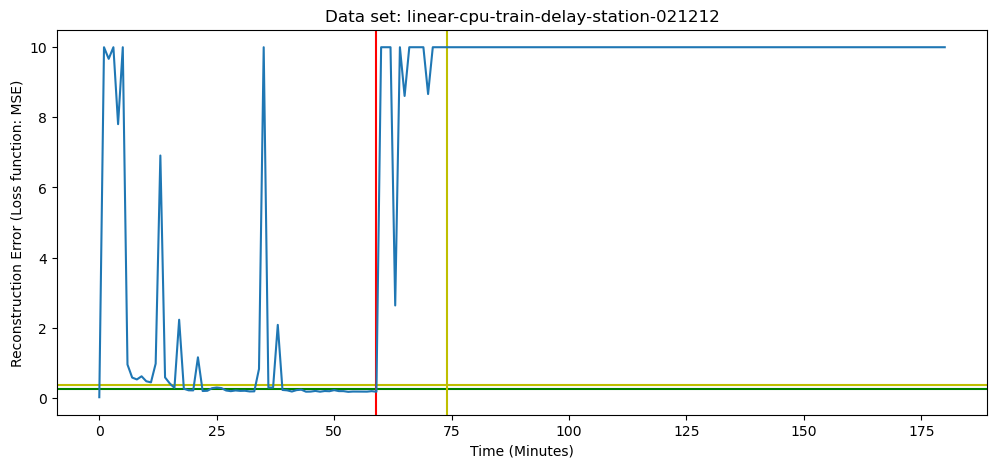

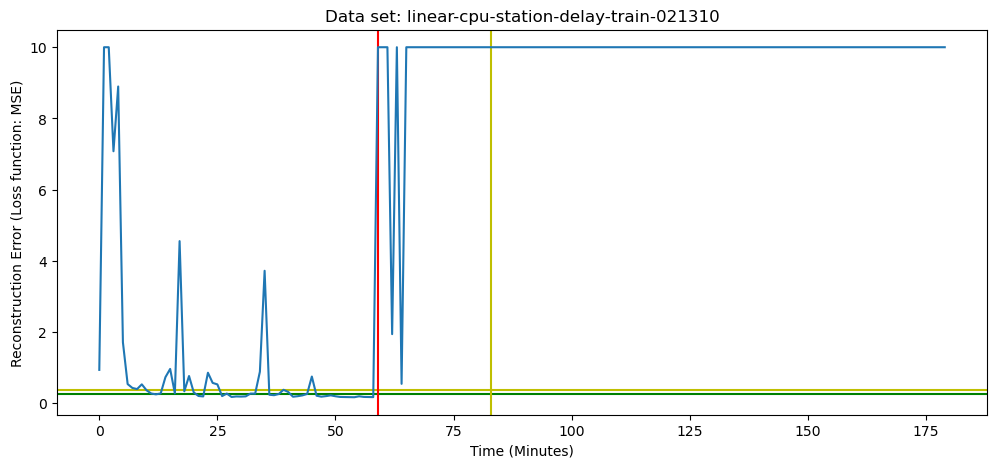

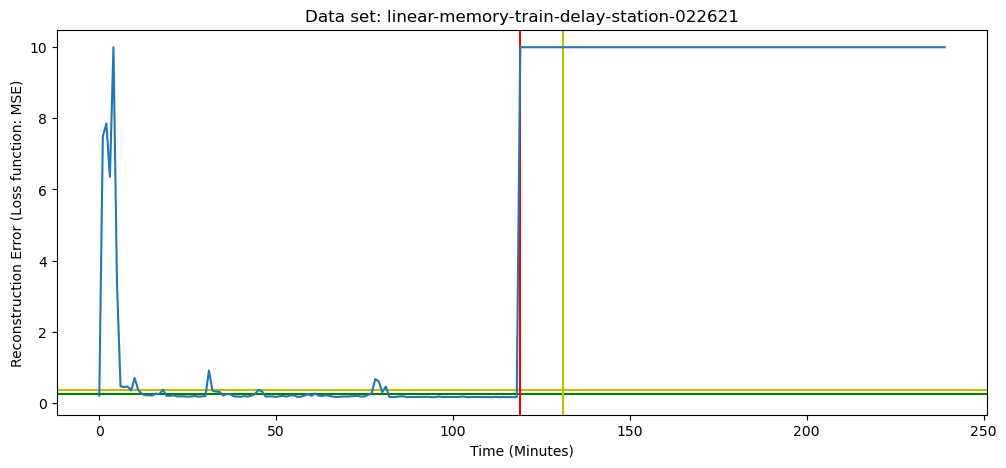

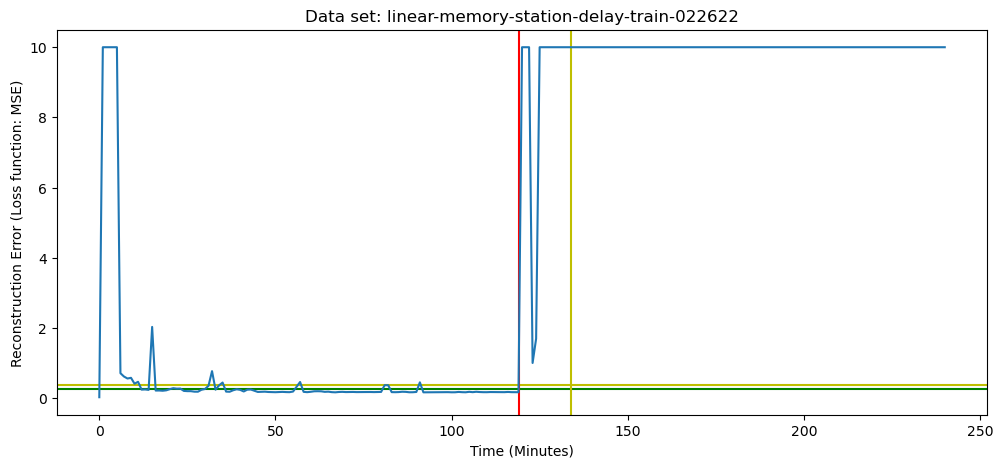

In [18]:
# -- Detect point-level anomalies (predictions), save, and visualize

for test_data_set_idx, test_data_set_code in enumerate(prod_data_set_codes):

    # Calculate a point-level reconstruction errors (output: list of MSE's for each point)
    test_point_reconstruction_errors = tf.keras.losses.mse(test_reconstructions[test_data_set_idx], test_data_arrays[test_data_set_idx])
    # test_point_reconstruction_errors = tf.keras.losses.mape(test_reconstructions[test_data_set_idx], test_data_arrays[test_data_set_idx])

    # Classify a point as an anomaly if its reconstruction error is greater than the point-level threshold (output: list of predictions per each point)
    test_predictions = get_predictions(test_point_reconstruction_errors, threshold_up)
    test_predictions = np.array(test_predictions)[0]

    # - Save the predictions (point level anomalies)
    
    # Transform point level anomalies into binary format (1 - prediction, 0 - no prediction)
    test_predictions_bin = [int(prediction) for prediction in test_predictions]
    
    # Create a target folder if does not exist
    create_dir(predictions_dir_path)

    # Save the predictions as .csv
    with open(predictions_file_path.format(data_set_code=test_data_set_code, approach="a"), 'w') as f:
        write = csv.writer(f)
        for prediction_bin in test_predictions_bin:
            write.writerow([prediction_bin])

    # - Visualize the point-level reconstruction errors
    
    # Cut the reconstruction error value from the top for point-level visualization purposes
    point_level_re_for_visualisation = []
    for point_re in test_point_reconstruction_errors:
        if point_re > 10:
            point_re = 10

        point_level_re_for_visualisation.append(point_re)

    # Prot
    plt.figure(figsize = (12, 5))
    plt.title("Data set: {data_set_code}".format(data_set_code=test_data_set_code))
    plt.xlabel("Time (Minutes)")
    plt.ylabel("Reconstruction Error (Loss function: MSE)")
    plt.axhline(y = point_level_mean, color = 'g', linestyle = '-')
    plt.axhline(y = threshold_up, color = 'y', linestyle = '-')
    
    if test_data_set_code not in normal_data_sets:
        plt.axvline(x = int(data_sets_config[test_data_set_code][1]) - 1, color = 'r')
        plt.axvline(x = int(data_sets_config[test_data_set_code][2]) - 1, color = 'y')
    
    plt.plot(np.arange(len(point_level_re_for_visualisation)), point_level_re_for_visualisation)
    # plt.savefig("{test_data_set_code}.png".format(test_data_set_code=test_data_set_code), bbox_inches='tight')
    plt.show()

In [19]:
# -- Detect KPI-level anomalies using Z-score (diviation of RE from the RE on normal data)

# Loop by data sets
for data_set_idx, data_set_code in enumerate(prod_data_set_codes):

    # Skip normal data sets
    if data_set_code in normal_data_sets:
        continue

    print(data_set_code)
    
    # Load the names of the kpis not seen in prod
    if DONT_USE_KPIS_NOT_SEEN_IN_PROD:
        kpis_not_seen_in_production = get_kpis_not_seen_in_prod(kpis_not_seen_in_prod_file_path, data_set_code)

    # Calculate the reconstruction errors for each KPI's value within each point
    test_reconstruction_errors = np.abs(test_reconstructions[data_set_idx] - test_data_arrays[data_set_idx])

    # Create a two-dim array of anomalies (sets of anomalous KPIs for each point) in JSON format - anomalous_kpis_json

    anomalous_kpis_list = []
    anomalous_kpis_list_services_only = []
    
    ranked_nodes_dataset = []
    
    # Loop by time points
    for current_timestamp, point__ in enumerate(test_reconstruction_errors):

        anomalous_kpis_dict_one_point = {}
        anomalous_kpis_dict_one_point_services_only = {}
        
        # Loop by kpis
        for kpi_index, kpi_re in enumerate(point__):

            kpi_name = kpi_set[kpi_index]
            # kpi_node = kpi_name.split("_")[0]
            kpi_node = get_service_name(kpi_name, app_service_list)
            # print(kpi_node)
            kpi_metric = kpi_name.split("_")[1]

            if DONT_USE_KPIS_NOT_SEEN_IN_PROD:
                # exclude from the consideration the kpis that were not initially in the prod data sets
                if kpi_name in kpis_not_seen_in_production:
                    continue

            kpi_re_above_threshold = kpi_re - thresholds_per_metric_up[kpi_index]
            
            if kpi_re_above_threshold >= 0:

                # mean of the KPIs reconstruction errors on the Training Data
                kpi_mean = metric_means[kpi_index]
                # standard deviation of the KPIs reconstruction errors on the Training Data
                kpi_std = metric_stdevs[kpi_index]
            
                if kpi_std == 0:
                    continue

                # Z-score of the KPIs reconstruction error on the current time point
                """
                if get_kpi_type(kpi_name, discrete_metrics_pm, discrete_metrics_gm) == "ordinal":
                    z_score = np.abs(kpi_re - thresholds_per_metric_up[kpi_index]) / (round(kpi_std, 0) + 1)
                else:
                    z_score = np.abs(kpi_re - thresholds_per_metric_up[kpi_index]) / kpi_std
                """
                z_score = np.abs(kpi_re - thresholds_per_metric_up[kpi_index]) / kpi_std

                # Consider the app service and system related KPIs only
                if "lm_" not in kpi_name:
                    anomalous_kpis_dict_one_point[kpi_name] = z_score
                
                # Consider the app service related KPIs only to group by service
                if kpi_node in app_service_list:
                    anomalous_kpis_dict_one_point_services_only[kpi_name] = z_score

        # Sort and Append ALL anomalies of the time point to the LIST data structure
        anomalous_kpis_dict_one_point_sorted = dict(sorted(anomalous_kpis_dict_one_point.items(), key=lambda item: item[1], reverse=True))
        anomalous_kpis_list.append(anomalous_kpis_dict_one_point_sorted)
        
        # Append service anomalies to the LIST data structure
        anomalous_kpis_dict_one_point_services_only_sorted = dict(sorted(anomalous_kpis_dict_one_point_services_only.items(), key=lambda item: item[1], reverse=True))
        anomalous_kpis_list_services_only.append(anomalous_kpis_dict_one_point_services_only_sorted)
        
        #  -- Get node-level localization (ranking according to the total reconstruction error of the nodes' anom KPIs)
        # ranked_nodes_one_point = get_ranked_nodes_list_for_point_from_anomalous_kpis_re(anomalous_kpis_dict_one_point_sorted)
        ranked_nodes_one_point = get_ranked_nodes_list_for_point_from_anomalous_kpis_re(anomalous_kpis_dict_one_point_services_only_sorted, data_set_code, current_timestamp + 1)
        ranked_nodes_dataset.append(ranked_nodes_one_point)
        

    # - Save anomalies in CSV format (Service-related only)
    
    # Create a target folder if does not exist
    create_dir(anomalies_lists_services_only_dir_path)
    save_anomalies_to_csv(anomalies_lists_services_only_file_path, data_set_code, anomalous_kpis_list_services_only)
    
    # - Save anomalies in CSV format (ALL anomalous kpis)
    
    # Create a target folder if does not exist
    create_dir(anomalies_lists_dir_path)
    save_anomalies_to_csv(anomalies_lists_file_path, data_set_code, anomalous_kpis_list)

    # - Save node rankings based on KPI RE. For localization using RE!
    
    # Create a target folder if does not exist
    create_dir(localisations_by_reconstruction_error_dir_path)
    save_ranked_nodes(ranked_nodes_dataset, localisations_by_reconstruction_error_file_path, data_set_code)

linear-cpu-stress-ts-station-service-020211
linear-cpu-stress-ts-basic-service-020616
linear-cpu-stress-ts-train-service-020713
linear-memory-stress-ts-station-service-021917
linear-memory-stress-ts-train-service-021316
linear-memory-stress-ts-basic-service-022009
linear-network-delay-ts-station-service-013016
linear-network-delay-ts-basic-service-020911
linear-network-delay-ts-train-service-020116
linear-cpu-train-memory-station-020912
linear-cpu-station-memory-train-020810
linear-cpu-train-delay-station-021212
linear-cpu-station-delay-train-021310
linear-memory-train-delay-station-022621
linear-memory-station-delay-train-022622


In [20]:
# -- Define the consequitive negatives periods

consequitive_negatives_periods_ends = {}
for data_set_idx, data_set_code in enumerate(prod_data_set_codes):
    
    # Load predictions
    with open(predictions_file_path.format(data_set_code=data_set_code), newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        predictions = [int(row[0]) for row in csv_reader]
    
    consequitive_negatives_periods_ends[data_set_code] = []
    consequitive_negatives_counter = 0
    for prediction_idx, prediction in enumerate(predictions):

        prediction = int(prediction)
        time_point = prediction_idx + 1

        if prediction == 0:
            consequitive_negatives_counter += 1
        else:
            consequitive_negatives_counter = 0

        if consequitive_negatives_counter == conseq_period_duration:
            consequitive_negatives_periods_ends[data_set_code].append(time_point)
            consequitive_negatives_counter -= 1

In [21]:
# -- Read anomalies with 1st Z-scores into kpi_score_matrix (dict[data_set_code]->list[row_idx]->dict[kpi_name])

kpi_score_matrix = {}
for data_set_code in prod_data_set_codes:
    
    kpi_score_matrix[data_set_code] = []

    # Load anomalies with Z-scores
    kpi_and_scores = []
    with open(anomalies_lists_services_only_file_path.format(data_set_code=data_set_code), "r") as file_in:
        csv_reader = csv.reader(file_in, delimiter=',')
        for row in csv_reader:
            kpi_and_scores.append([kpi_and_score for kpi_and_score in row])
            
    
    for row_idx, row in enumerate(kpi_and_scores):
        
        current_minute = row_idx + 1

        kpi_score_matrix[data_set_code].append(row_idx)
        kpi_score_matrix[data_set_code][row_idx] = {}

        for kpi_and_score in row:
            kpi_and_score_components = kpi_and_score.split(" : ")
            
            kpi_name = kpi_and_score_components[0]
            kpi_score = kpi_and_score_components[1]
            
            kpi_score_matrix[data_set_code][row_idx][kpi_name] = kpi_score

In [22]:
# -- Calculate the 2nd z-scores (diviation of the current 1st z-score from the 1st z-score on 20 minutes period) and rank the nodes according to the 2nd z-score

for data_set_code in prod_data_set_codes:

    kpi_score_matrix_of_dataset = kpi_score_matrix[data_set_code]
    
    kpi_score_matrix_of_dataset_new = []
    ranked_nodes_dataset = []

    for row_idx, row in enumerate(kpi_score_matrix_of_dataset):
        
        kpi_score_matrix_of_dataset_new.append(row_idx)
        kpi_score_matrix_of_dataset_new[row_idx] = {}
        
        current_minute = row_idx + 1
        
        for kpi_name in kpi_score_matrix_of_dataset[row_idx]:
            kpi_score_matrix_of_dataset[row_idx][kpi_name] = float(kpi_score_matrix_of_dataset[row_idx][kpi_name])

        last_conseq_period_end = get_the_end_of_the_last_conseq_period(consequitive_negatives_periods_ends[data_set_code], current_minute)


        if last_conseq_period_end != None and last_conseq_period_end >= conseq_period_duration:
            last_conseq_period_start = last_conseq_period_end - conseq_period_duration + 1
            
            for kpi_name in kpi_score_matrix_of_dataset[row_idx]:
                kpi_last_conseq_period_scores = []
                for dict_ in kpi_score_matrix_of_dataset[last_conseq_period_start : last_conseq_period_end + 1]:
                    if kpi_name in dict_:
                        kpi_score = dict_[kpi_name]
                        kpi_last_conseq_period_scores.append(kpi_score)

                if len(kpi_last_conseq_period_scores) == 0:
                    kpi_last_conseq_period_scores_mean = 0
                    kpi_last_conseq_period_scores_std = 1
                else:
                    kpi_last_conseq_period_scores_mean = np.mean(kpi_last_conseq_period_scores)
                    kpi_last_conseq_period_scores_std = np.std(kpi_last_conseq_period_scores)
                    
                if kpi_last_conseq_period_scores_std == 0:
                    kpi_last_conseq_period_scores_std = 1

                # kpi_score_matrix_of_dataset_new[row_idx][kpi_name] = kpi_score_matrix_of_dataset[row_idx][kpi_name] - kpi_last_conseq_period_scores_mean
                kpi_score_matrix_of_dataset_new[row_idx][kpi_name] = (kpi_score_matrix_of_dataset[row_idx][kpi_name] - kpi_last_conseq_period_scores_mean)/kpi_last_conseq_period_scores_std

        ranked_nodes_one_point = get_ranked_nodes_list_for_point_from_anomalous_kpis_re(kpi_score_matrix_of_dataset_new[row_idx], data_set_code, current_minute)
        ranked_nodes_dataset.append(ranked_nodes_one_point)

    # - Save anomalies in CSV format (Service-related only)
    
    # Create a target folder if does not exist
    create_dir(anomalies_lists_services_only_sliding_window_dir_path)
    save_anomalies_to_csv(anomalies_lists_services_only_sliding_window_file_path, data_set_code, kpi_score_matrix_of_dataset_new)
    
    # - Save node rankings based on KPI RE Z-score with sliding window. For localization using Z-score with sliding window
    
    # Create a target folder if does not exist
    create_dir(localisations_by_reconstruction_error_sliding_window_dir_path)
    save_ranked_nodes(ranked_nodes_dataset, localisations_by_reconstruction_error_sliding_window_file_path, data_set_code)